## Scanpy for morphological data

We try to use scanpy to analyze morphological data from CellProfiler outputs.
An example pipeline is explained here and is used as template for this notebook:
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad


We load data from an time-lapse experiment with single-cell morphological features.
Cardiomyocytes have been cultured in 96-well plates and treated with different probes.
They were stained with a fluorescent marker for live cells and imaged at certain time points
with a high-throughput microscope.
Next, the images were analyzed with the software CellProfiler to store morphological
features for every cell.
The data is already stored in .h5ad format to make them available as to anndata.
To reduce memory we just open a subsample of all cells with 10% of all cells per well.


In [2]:
# parse config file
with open('../config.yml', 'r') as f:
    cfg = yaml.safe_load(f)

input = cfg['input']
output = cfg['output']

In [3]:
adata = ad.read_h5ad(os.path.join(output, 'morph_data_ss_10.h5ad'))
adata

AnnData object with n_obs × n_vars = 3830 × 407
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Neig

In [7]:
adata[1, 3].X = 3

adata[1, 3].X

ArrayView([[3.]], dtype=float32)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for group in adata.obs['BatchNumber'].unique():
    adata[adata.obs['BatchNumber'] == group].X = scaler.fit_transform(
        adata[adata.obs['BatchNumber'] == group].X)


C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\sklearn\utils\extmath.py:687: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)


In [10]:
adata[adata.obs['BatchNumber'] == 1].X

ArrayView([[ 0.03223437,  0.03223437, -1.0824482 , ...,  0.79998404,
             0.769684  ,  0.8076788 ],
           [-0.15466152, -0.15466152,  0.70758885, ...,  0.6040783 ,
             0.57950586,  0.5858247 ],
           [ 0.03412221,  0.03412221,  0.01150945, ...,  1.0103137 ,
             0.9977062 ,  0.9970425 ],
           ...,
           [-0.31009346, -0.31009346,  0.07879159, ..., -0.5187808 ,
            -0.51635367, -0.51477975],
           [-1.233246  , -1.233246  , -0.02545419, ..., -0.6362702 ,
            -0.6336818 , -0.6382976 ],
           [ 1.1328435 ,  1.1328435 , -0.79753745, ..., -0.05525636,
            -0.07612563, -0.03768636]], dtype=float32)

The outputs shows that we have an annotated dataset with 3830 cells and
407 features.

### Preprocessing

Drop features with invalid values:

In [167]:
# batch correction
sc.pp.combat(adata, key="BatchNumber", covariates=["PlateNumber"])

In [97]:
from morphelia.utils.pp import *

adata = unique_feats(adata, verbose=True)
adata = drop_nan(adata, verbose=True)
adata

Dropped features: Index([], dtype='object')
Dropped variables: []


AnnData object with n_obs × n_vars = 3830 × 368
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Neig

Remove outlier cells with very high or low values for size
or intesity. This is probably due to segmentation errors or dead cells.

In [99]:
shape = [s for s in adata.var.index if 'Cells_AreaShape_Area' in s][0]
intens = [s for s in adata.var.index if 'Intensity_MeanIntensity_' in s][0]

print(shape)
print(intens)

Cells_AreaShape_Area
Cells_Intensity_MeanIntensity_CalceinAM


C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()
C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


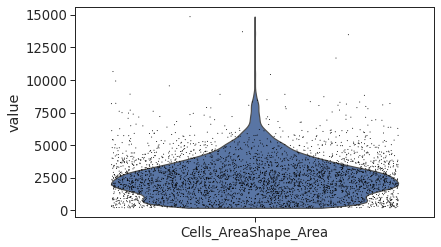

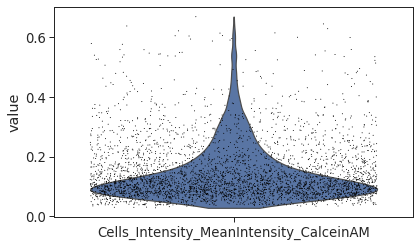

In [100]:
sc.pl.violin(adata, shape,
             jitter=0.4)
sc.pl.violin(adata, intens, jitter=0.4)

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


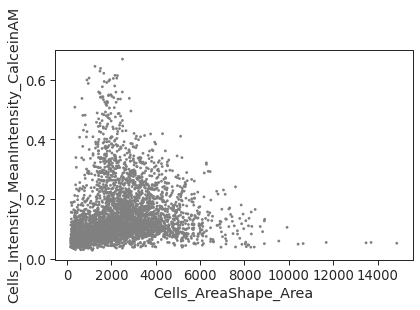

In [101]:
sc.pl.scatter(adata, x=shape, y=intens)

In [102]:
from morphelia.utils.pp import *

adata = filter_cells(adata, shape, side='both')
adata = filter_cells(adata, intens, side='right')

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


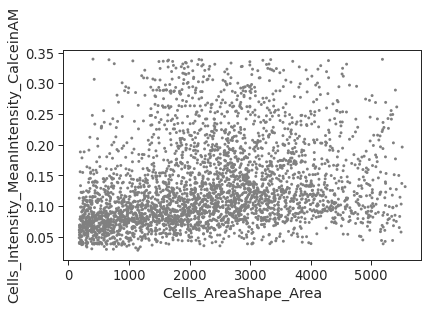

In [103]:
sc.pl.scatter(adata, x=shape, y=intens)

Three variables were dropped because of invalid values.

Now logarithmize and scale the data.

In [163]:
sc.pp.log1p(adata)
# adata.X[np.isinf(adata.X)]
adata = min_max_scaler(adata)

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\preprocessing\_simple.py:354: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [107]:
adata = drop_nan(adata, verbose=True)

Dropped variables: ['Cells_Texture_InfoMeas1_CalceinAM_20_03_256', 'Cells_Texture_InfoMeas1_CalceinAM_20_02_256', 'Cells_Texture_Correlation_CalceinAM_20_03_256', 'Cells_Texture_InfoMeas1_CalceinAM_20_00_256', 'Cells_Texture_InfoMeas1_CalceinAM_3_01_256', 'Cells_Texture_InfoMeas1_CalceinAM_10_03_256', 'Cells_Texture_InfoMeas1_CalceinAM_3_00_256', 'Cells_Texture_InfoMeas1_CalceinAM_20_01_256', 'Cells_Texture_InfoMeas1_CalceinAM_3_02_256', 'Cells_Texture_InfoMeas1_CalceinAM_10_02_256', 'Cells_Texture_InfoMeas1_CalceinAM_10_00_256', 'Cells_Texture_InfoMeas1_CalceinAM_3_03_256', 'Cells_Texture_InfoMeas1_CalceinAM_10_01_256', 'Cells_Texture_Correlation_CalceinAM_20_00_256', 'Cells_Texture_Correlation_CalceinAM_20_02_256', 'Cells_Texture_Correlation_CalceinAM_10_03_256', 'Cells_Texture_Correlation_CalceinAM_20_01_256', 'Cells_Texture_Correlation_CalceinAM_10_02_256', 'Cells_Texture_Correlation_CalceinAM_10_00_256', 'Cells_Texture_Correlation_CalceinAM_10_01_256']


In [108]:
adata

AnnData object with n_obs × n_vars = 3476 × 310
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Neig

Identify highly variable features

In [109]:
sc.pp.highly_variable_genes(adata)

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


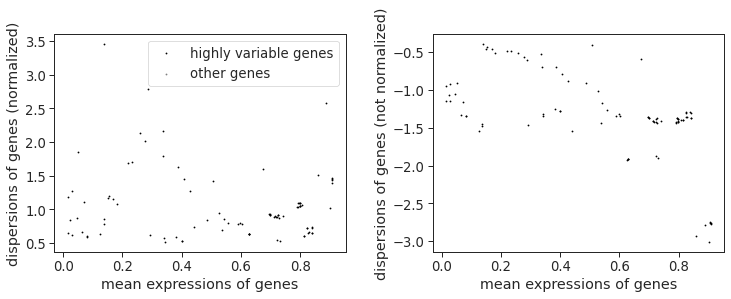

In [162]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the scaled and logarithmized raw feature space
for later use in differential testing and visualizations. Thit simply freezes the state of the
AnnData object.

In [111]:
adata.raw = adata

Actually do the filtering

In [112]:
adata = adata[:, adata.var.highly_variable]

Now we scale each feature to unit variance

In [ ]:
adata[adata.obs["Metadata_Time"] == 0].X = sc.pp.scale(adata[adata.obs["Metadata_Time"] == 0].copy(),
                                                       max_value=10)

In [191]:
adata[adata.obs["Metadata_Time"] == 0].X

ArrayView([[ 2.5200000e+03,  2.5200000e+03, -1.8502533e-11, ...,
             8.3290961e+02,  8.2135443e+02,  8.3426959e+02],
           [ 2.2230000e+03,  2.2230000e+03,  1.2121859e-11, ...,
             7.1948621e+02,  7.1023077e+02,  7.0647028e+02],
           [ 2.5230000e+03,  2.5230000e+03,  2.1316282e-13, ...,
             9.5468408e+02,  9.5459088e+02,  9.4335278e+02],
           ...,
           [ 1.6190000e+03,  1.6190000e+03, -1.9753088e-12, ...,
             6.2008313e+02,  6.3617334e+02,  6.1703784e+02],
           [ 4.9070000e+03,  4.9070000e+03, -2.2993163e-11, ...,
             1.8416320e+03,  1.8422897e+03,  1.8470922e+03],
           [ 2.4170000e+03,  2.4170000e+03, -6.0182970e-12, ...,
             5.5975934e+02,  5.5744592e+02,  5.7269757e+02]],
          dtype=float32)

In [54]:
adata

AnnData object with n_obs × n_vars = 3672 × 12
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Neigh

### Trajectory

In [51]:
import scanpy.external as sce
import pandas as pd

In [114]:
adata.obs['Metadata_Time_Cat'] = pd.Categorical(adata.obs['Metadata_Time'].astype(str),
                                                categories=list(adata.obs['Metadata_Time'].astype(str).unique()))

In [115]:
sce.tl.harmony_timeseries(adata, tp='Metadata_Time_Cat', n_components=50)

Running PCA with 12 components
Nearest neighbor computation...


C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\harmony\core.py:70: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  kNN = temp.uns['neighbors']['distances']


Constucting affinities between 0 and 3...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 3 and 6...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 6 and 9...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 9 and 12...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 12 and 24...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 24 and 30...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 30 and 36...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 36 and 48...
t+1 neighbors of t...
t neighbors of t+1...


100%|██████████| 500/500 [01:22<00:00,  6.10it/s]

BarnesHut Approximation  took  16.85  seconds
Repulsion forces  took  60.36  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  1.79  seconds
AdjustSpeedAndApplyForces step  took  1.24  seconds


In [116]:
adata

AnnData object with n_obs × n_vars = 3476 × 91
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Neigh

In [117]:
sce.tl.palantir(adata,
                n_components=5,
                knn=30,
                use_adjacency_matrix=True,
                distances_key='harmony_aff_aug')

In [118]:
sc.tl.tsne(adata, use_rep='X_palantir_multiscale')

In [119]:
adata.var.index

Index(['Cells_Granularity_17_CalceinAM', 'Cells_Granularity_16_CalceinAM',
       'Cells_Neighbors_PercentTouching_Adjacent',
       'Cells_Granularity_15_CalceinAM', 'Cells_Granularity_14_CalceinAM',
       'Cells_Neighbors_PercentTouching_20', 'Cells_Granularity_21_CalceinAM',
       'Cells_Granularity_20_CalceinAM', 'Cells_Granularity_18_CalceinAM',
       'Cells_Granularity_19_CalceinAM',
       'Cells_Texture_DifferenceVariance_CalceinAM_20_00_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_10_02_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_10_00_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_20_03_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_3_03_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_3_02_256',
       'Cells_AreaShape_Zernike_8_0',
       'Cells_Texture_DifferenceVariance_CalceinAM_3_00_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_3_01_256',
       'Cells_Texture_AngularSecondMoment_CalceinAM_20_01_256',
  

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


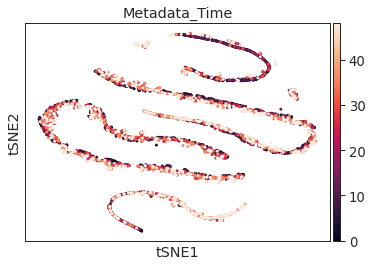

In [122]:
sc.pl.tsne(adata, color="Metadata_Time")

### Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA),
which reveals the main axes of variation and denoises the data.

In [123]:
sc.tl.pca(adata, svd_solver='arpack')

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


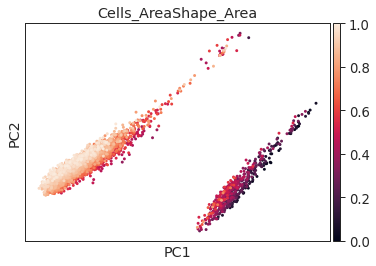

In [124]:
sc.pl.pca(adata, color='Cells_AreaShape_Area')

Let us inspect the contribution of single PCs to the total variance in the data.
This gives us information about how many PCs we should consider in order to
compute the neighborhood relations of cells, e.g. used in the clustering
function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough
estimate of the number of PCs does fine.

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


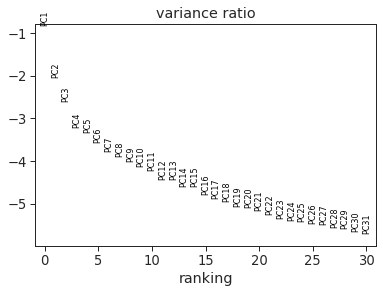

In [125]:
sc.pl.pca_variance_ratio(adata, log=True)

### Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA
representation of the data matrix. You might simply use default values here.

In [126]:
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=30)

### Embedding the neighborhood graph
We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below.
It is potentially more faithful to the global connectivity of the manifold
than tSNE, i.e., it better preserves trajectories.
In some ocassions, you might still observe disconnected clusters and
similar connectivity violations. They can usually be remedied by running:

In [127]:
sc.tl.umap(adata)

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


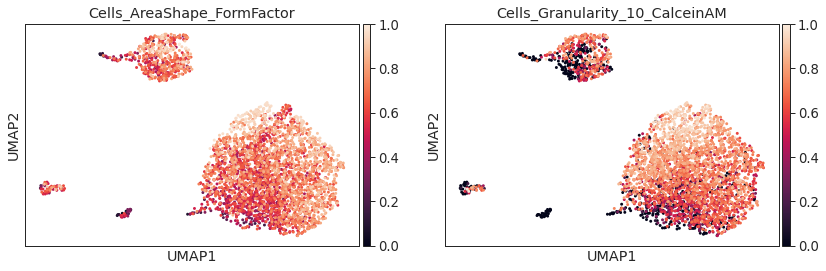

In [128]:
sc.pl.umap(adata, color=['Cells_AreaShape_FormFactor', 'Cells_Granularity_10_CalceinAM'])

As we set the .raw attribute of adata, the previous plots showed the “raw”
(normalized, logarithmized, but uncorrected) gene expression.
You can also plot the scaled and corrected gene expression by explicitly
stating that you don’t want to use .raw.



In [ ]:
vars = adata.var.index.tolist()
len(vars)

In [ ]:
sc.pl.umap(adata, color=vars[:10],
           use_raw=False)

### Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden
graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018).
Note that Leiden clustering directly clusters the neighborhood graph of cells,
which we already computed in the previous section.

In [132]:
sc.tl.leiden(adata, resolution=0.2)

Plot the clusters, which agree quite well with the result of Seurat.

In [133]:
adata.obs['leiden']

0-0      1
1-0      1
2-0      0
3-0      1
5-0      0
        ..
689-8    0
690-8    0
691-8    0
692-8    2
693-8    0
Name: leiden, Length: 3476, dtype: category
Categories (5, object): ['0', '1', '2', '3', '4']

NotImplementedError: isna is not defined for MultiIndex

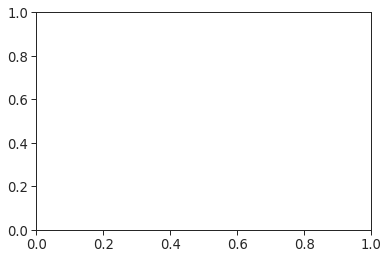

In [134]:
sc.pl.umap(adata, color='leiden')

### Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster.
For this, by default, the .raw attribute of AnnData is used in case it has been initialized before.
The simplest and fastest method to do so is the t-test.

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


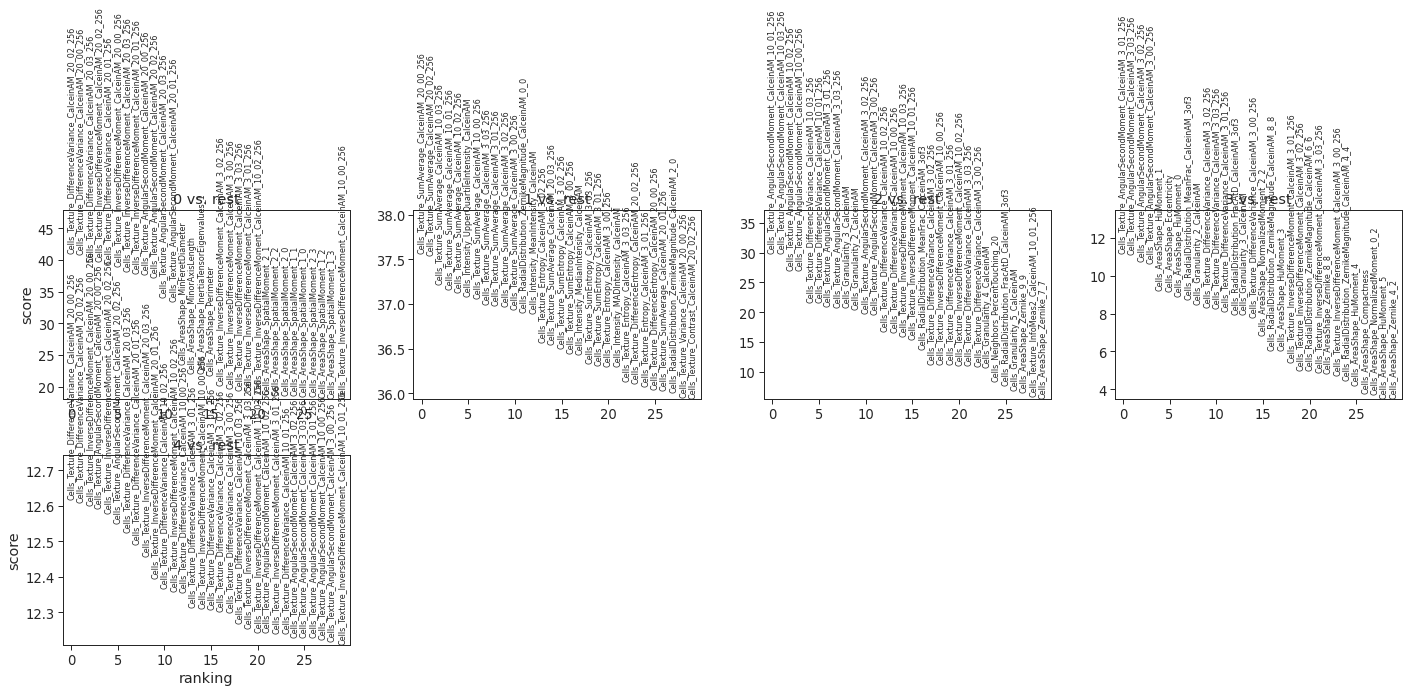

In [136]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

Show the 10 top ranked genes per cluster 0, 1, …, 4 in a dataframe.

In [137]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p
0,Cells_Texture_DifferenceVariance_CalceinAM_20_...,0.0,Cells_Texture_SumAverage_CalceinAM_20_00_256,6.818035e-309,Cells_Texture_AngularSecondMoment_CalceinAM_10...,2.193241e-196,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,5.511446e-29,Cells_Texture_DifferenceVariance_CalceinAM_20_...,1.654917e-36
1,Cells_Texture_DifferenceVariance_CalceinAM_20_...,0.0,Cells_Texture_SumAverage_CalceinAM_20_02_256,1.279063e-308,Cells_Texture_AngularSecondMoment_CalceinAM_10...,6.407725e-196,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,7.235819e-29,Cells_Texture_DifferenceVariance_CalceinAM_20_...,1.820595e-36
2,Cells_Texture_DifferenceVariance_CalceinAM_20_...,0.0,Cells_Texture_SumAverage_CalceinAM_10_03_256,2.892243e-303,Cells_Texture_AngularSecondMoment_CalceinAM_10...,1.811708e-161,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,4.743107e-27,Cells_Texture_InverseDifferenceMoment_CalceinA...,2.051934e-36
3,Cells_Texture_InverseDifferenceMoment_CalceinA...,0.0,Cells_Texture_SumAverage_CalceinAM_10_01_256,2.392044e-302,Cells_Texture_AngularSecondMoment_CalceinAM_10...,5.164232e-161,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,1.323166e-26,Cells_Texture_AngularSecondMoment_CalceinAM_20...,2.324509e-36
4,Cells_Texture_DifferenceVariance_CalceinAM_20_...,0.0,Cells_Texture_SumAverage_CalceinAM_10_02_256,9.797845e-302,Cells_Texture_DifferenceVariance_CalceinAM_10_...,6.669161e-105,Cells_AreaShape_HuMoment_1,2.615201e-20,Cells_Texture_InverseDifferenceMoment_CalceinA...,2.749422e-36


In [138]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4
0,Cells_Texture_DifferenceVariance_CalceinAM_20_...,Cells_Texture_SumAverage_CalceinAM_20_00_256,Cells_Texture_AngularSecondMoment_CalceinAM_10...,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,Cells_Texture_DifferenceVariance_CalceinAM_20_...
1,Cells_Texture_DifferenceVariance_CalceinAM_20_...,Cells_Texture_SumAverage_CalceinAM_20_02_256,Cells_Texture_AngularSecondMoment_CalceinAM_10...,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,Cells_Texture_DifferenceVariance_CalceinAM_20_...
2,Cells_Texture_DifferenceVariance_CalceinAM_20_...,Cells_Texture_SumAverage_CalceinAM_10_03_256,Cells_Texture_AngularSecondMoment_CalceinAM_10...,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,Cells_Texture_InverseDifferenceMoment_CalceinA...
3,Cells_Texture_InverseDifferenceMoment_CalceinA...,Cells_Texture_SumAverage_CalceinAM_10_01_256,Cells_Texture_AngularSecondMoment_CalceinAM_10...,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,Cells_Texture_AngularSecondMoment_CalceinAM_20...
4,Cells_Texture_DifferenceVariance_CalceinAM_20_...,Cells_Texture_SumAverage_CalceinAM_10_02_256,Cells_Texture_DifferenceVariance_CalceinAM_10_...,Cells_AreaShape_HuMoment_1,Cells_Texture_InverseDifferenceMoment_CalceinA...
5,Cells_Texture_InverseDifferenceMoment_CalceinA...,Cells_Intensity_UpperQuartileIntensity_CalceinAM,Cells_Texture_DifferenceVariance_CalceinAM_10_...,Cells_AreaShape_Eccentricity,Cells_Texture_AngularSecondMoment_CalceinAM_20...
6,Cells_Texture_InverseDifferenceMoment_CalceinA...,Cells_Texture_SumAverage_CalceinAM_10_00_256,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,Cells_AreaShape_HuMoment_0,Cells_Texture_DifferenceVariance_CalceinAM_20_...
7,Cells_Texture_InverseDifferenceMoment_CalceinA...,Cells_Texture_SumAverage_CalceinAM_3_03_256,Cells_Texture_AngularSecondMoment_CalceinAM_3_...,Cells_RadialDistribution_MeanFrac_CalceinAM_3of3,Cells_Texture_DifferenceVariance_CalceinAM_20_...
8,Cells_Texture_AngularSecondMoment_CalceinAM_20...,Cells_Texture_SumAverage_CalceinAM_3_01_256,Cells_Granularity_3_CalceinAM,Cells_Granularity_2_CalceinAM,Cells_Texture_InverseDifferenceMoment_CalceinA...
9,Cells_Texture_AngularSecondMoment_CalceinAM_20...,Cells_Texture_SumAverage_CalceinAM_3_02_256,Cells_Granularity_2_CalceinAM,Cells_Texture_DifferenceVariance_CalceinAM_3_0...,Cells_Texture_InverseDifferenceMoment_CalceinA...


Save the top features as marker features

In [158]:
marker_feats = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[:20, :].values.flatten().tolist()
marker_feats

['Cells_Texture_DifferenceVariance_CalceinAM_20_02_256',
 'Cells_Texture_SumAverage_CalceinAM_20_00_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_10_01_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_3_01_256',
 'Cells_Texture_DifferenceVariance_CalceinAM_20_00_256',
 'Cells_Texture_DifferenceVariance_CalceinAM_20_00_256',
 'Cells_Texture_SumAverage_CalceinAM_20_02_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_10_03_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_3_03_256',
 'Cells_Texture_DifferenceVariance_CalceinAM_20_02_256',
 'Cells_Texture_DifferenceVariance_CalceinAM_20_03_256',
 'Cells_Texture_SumAverage_CalceinAM_10_03_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_10_02_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_3_02_256',
 'Cells_Texture_InverseDifferenceMoment_CalceinAM_20_00_256',
 'Cells_Texture_InverseDifferenceMoment_CalceinAM_20_02_256',
 'Cells_Texture_SumAverage_CalceinAM_10_01_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_10_0

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


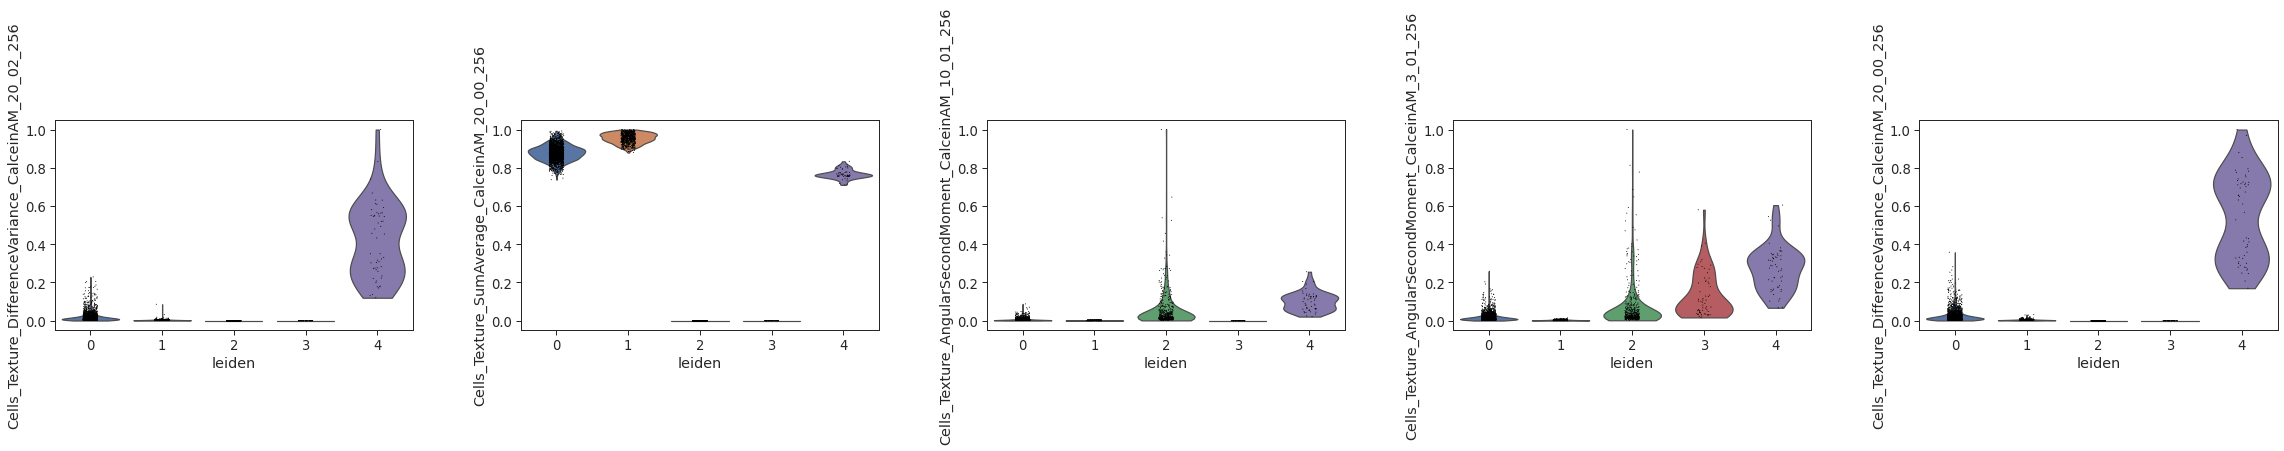

In [154]:
sc.pl.violin(adata, marker_feats, groupby='leiden')

In [159]:
mf = [m for m in marker_feats if m in adata.var_names]
mf

['Cells_Texture_SumAverage_CalceinAM_20_00_256',
 'Cells_Texture_DifferenceVariance_CalceinAM_20_00_256',
 'Cells_Texture_DifferenceVariance_CalceinAM_20_00_256',
 'Cells_Texture_SumAverage_CalceinAM_20_02_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_10_03_256',
 'Cells_Texture_DifferenceVariance_CalceinAM_20_03_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_20_02_256',
 'Cells_Texture_InverseDifferenceMoment_CalceinAM_20_03_256',
 'Cells_Texture_DifferenceVariance_CalceinAM_20_03_256',
 'Cells_Texture_InverseDifferenceMoment_CalceinAM_20_01_256',
 'Cells_Texture_SumAverage_CalceinAM_3_03_256',
 'Cells_Texture_SumAverage_CalceinAM_3_01_256',
 'Cells_Texture_InverseDifferenceMoment_CalceinAM_20_03_256',
 'Cells_Texture_AngularSecondMoment_CalceinAM_20_02_256',
 'Cells_Texture_SumAverage_CalceinAM_3_02_256',
 'Cells_Texture_DifferenceVariance_CalceinAM_3_02_256',
 'Cells_Texture_InverseDifferenceMoment_CalceinAM_20_01_256',
 'Cells_Texture_SumAverage_CalceinAM_3_00_256',
 'Ce

C:\Users\amarx\Anaconda3\envs\morphelia\lib\site-packages\scanpy\plotting\_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


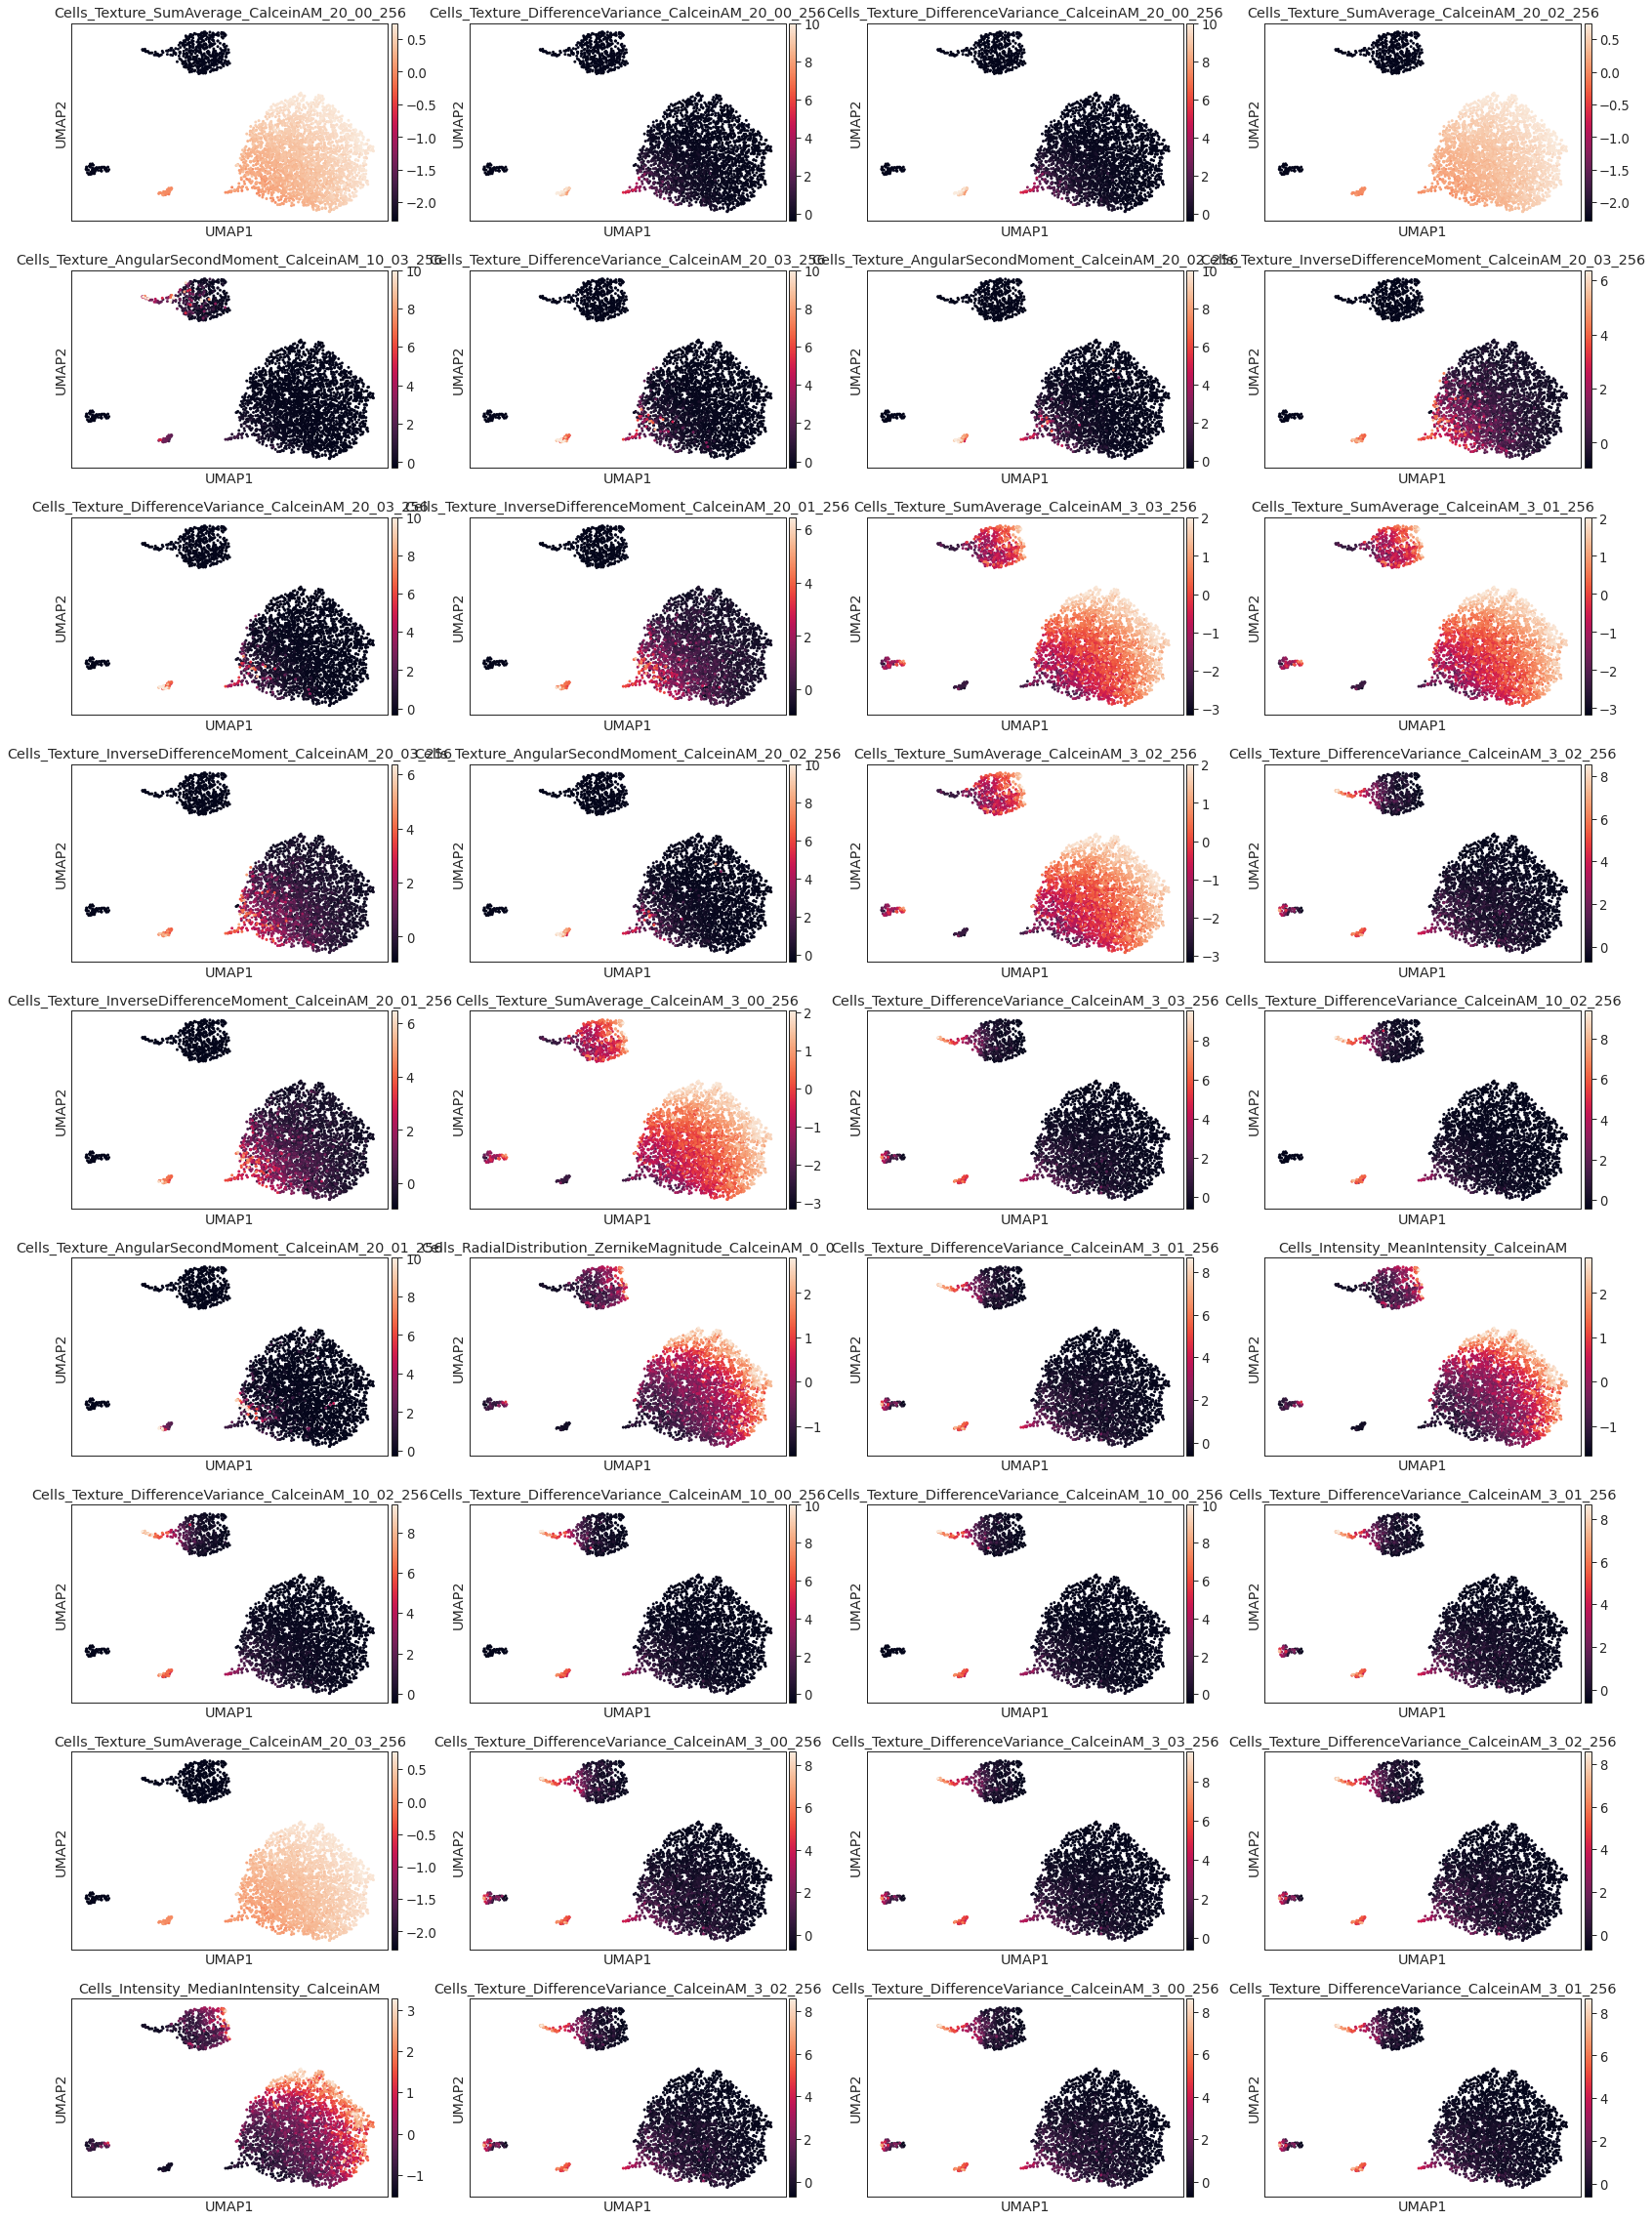

In [160]:
sc.pl.umap(adata, color=mf, use_raw=False)

In [148]:
adata.var

,highly_variable,means,dispersions,dispersions_norm,mean,std
Cells_Granularity_17_CalceinAM,True,0.407057,-0.796514,1.449208,0.356272,0.319479
Cells_Granularity_16_CalceinAM,True,0.427198,-0.887540,1.276338,0.378516,0.315193
Cells_Neighbors_PercentTouching_Adjacent,True,0.507027,-0.410453,1.414688,0.422412,0.415857
Cells_Granularity_15_CalceinAM,True,0.486051,-0.916042,0.840701,0.434548,0.327692
Cells_Granularity_14_CalceinAM,True,0.526498,-1.014720,0.945020,0.477060,0.324230
...,...,...,...,...,...,...
Cells_Texture_SumVariance_CalceinAM_20_02_256,True,0.717931,-1.429803,0.883674,0.676887,0.310458
Cells_Texture_SumVariance_CalceinAM_20_01_256,True,0.699056,-1.370542,0.921137,0.656736,0.313042
Cells_Texture_Contrast_CalceinAM_20_02_256,True,0.740880,-1.412963,0.896509,0.698365,0.317443
Cells_Texture_Contrast_CalceinAM_20_00_256,True,0.727268,-1.441479,0.874775,0.686131,0.311815
